---
title: "Training spiking neural networks, fast."

date: 2022-11-27
lastmod: 2022-11-27
draft: false

tags: ["SNN"]
summary: "How to use caching and EXODUS to speed up training by a factor of 10."

image:
  caption: "Image credit: Gregor Lenz"
---

Spiking neural networks (SNN) can be notoriously slow to train. A special case of recurrent neural network, they work with sequential inputs and rely on a form of gradient computation through time, which in the most common scenario is backpropagation through time. Given that events from event cameras or silicon cochlears have a temporal resolution of down to microseconds, the amount of time steps per sample can easily become the largest dimension in the input sample. 

This would not be a problem if we trained on the extremely sparse data in continuous time directly, but the legacy of ANN machine learning frameworks has it that we have to work with dense tensors to train our SNN. That means that for a visual event stream input (think video) of spatial size (2, 128, 128) for channels, y and x we not only deal with some 10 frames per second but potentially hundreds per second, which increases input dimensions by a lot. 

When training a neural network of any kind, one might think about how the learning rate or model size affect training time. But when it comes to training *faster*, optimizing data movement is crucial. 3 out of the first 4 points in [this list](https://www.reddit.com/r/MachineLearning/comments/kvs1ex/d_here_are_17_ways_of_making_pytorch_training/) weighted after potential speed-up have to do with how data is shaped and moved around between actual computations. It makes a huge difference, because training faster with the same hardware means getting results faster, and being able to iterate quicker.

For this post we train an SNN using [Sinabs](https://github.com/synsense/sinabs) based on PyTorch and surrogate gradients, which means that in the forward pass we use the heavily quantized output of spiking layers but in the backward pass we use a smoother surrogate function based on the internal state of the neurons. We'll use the [Heidelberg Spiking Speech Commands](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) dataset to train our network to do audio stream classification. We'll benchmark different data loading strategies using [Tonic](https://github.com/neuromorphs/tonic) and show that with the right strategy, we can achieve a 10-fold speed-up compared to the naïve approach.

For all our benchmarks, we already assume multiple worker loading threads and pinning the GPU memory. We'll increase throughput by using different forms of caching to disk or GPU. By applying deterministic transformations upfront and saving the new tensor, we can save a lot of time during training. 
This tutorial is run on a machine with Ubuntu 20.04, an Intel Core i7-8700K CPU @ 3.70GHz, a Samsung SSD 850 and an NVIDIA GeForce RTX 2070 GPU.

All data from neuromorphic datasets in Tonic is provided as NxD numpy arrays. We'll need to transform this into a dense tensor to serve it to the GPU, and we'll also do some downsampling of time steps. Let's first define the transform. We know that samples of audio input data are 0.8-1.2s long across 700 frequency channels at microsecond resolution. We'll [downsample](https://tonic.readthedocs.io/en/latest/reference/generated/tonic.transforms.Downsample.html#tonic.transforms.Downsample) each sample to 100 channels, [bin](https://tonic.readthedocs.io/en/latest/reference/generated/tonic.transforms.ToFrame.html#tonic.transforms.ToFrame) events every 4 ms to one frame and [cut](https://tonic.readthedocs.io/en/latest/reference/generated/tonic.transforms.CropTime.html#tonic.transforms.CropTime) samples that are longer than 1s. That leaves us with a maximum of 250 time steps per sample.

In [5]:
from tonic import transforms

dt = 4000  # all time units in Tonic in us
encoding_dim = 100

dense_transform = transforms.Compose(
    [
        transforms.Downsample(spatial_factor=encoding_dim / 700),
        transforms.CropTime(max=1e6),
        transforms.ToFrame(
            sensor_size=(encoding_dim, 1, 1), time_window=dt, include_incomplete=True
        ),
    ]
)

Next we'll import the training dataset and assign the transform.

In [6]:
from tonic import datasets

dense_dataset = datasets.SSC("./data", split="train", transform=dense_transform)
print(f"This dataset has {len(dense_dataset)} samples.")

This dataset has 75466 samples.


Let's also plot one such dense tensor:

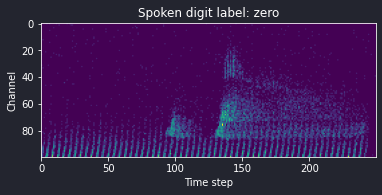

In [7]:
dense_sample, dense_target = dense_dataset[0]

import matplotlib.pyplot as plt

plt.style.use("dark_background")
plt.figure(facecolor='#23252f')
plt.imshow(dense_sample.squeeze().T)
plt.xlabel("Time step")
plt.ylabel("Channel")
plt.title("Spoken digit label: " + dense_dataset.classes[dense_target].decode("ascii"));

Let's also define a spiking model. We use a simple integrate-and-fire (IAF) feed-forward architecture. For each dataloading method, we're going to test two different models. One is a [Sinabs](https://sinabs.readthedocs.io) model which is pretty much pure PyTorch plus for loops and the second one is an [EXODUS](https://arxiv.org/abs/2205.10242) model, which is also based on PyTorch but vectorizes gradient computation for the time dimension using custom CUDA code. Both models compute the same activations and gradients, but the latter provides a significant speedup.

In [8]:
import torch.nn as nn
import sinabs.layers as sl
import sinabs.exodus.layers as el


class SNN(nn.Sequential):
    def __init__(self, backend, hidden_dim: int = 128):
        assert backend == sl or backend == el
        super().__init__(
            nn.Linear(encoding_dim, hidden_dim),
            backend.IAF(),
            nn.Linear(hidden_dim, hidden_dim),
            backend.IAF(),
            nn.Linear(hidden_dim, hidden_dim),
            backend.IAF(),
            nn.Linear(hidden_dim, 35),
        )


sinabs_model = SNN(backend=sl).cuda()
exodus_model = SNN(backend=el).cuda()

## 1. Naïve dataloading

We start with the first benchmark, where we load every sample from an hdf5 file on disk which provides us with a numpy array in memory. For each sample, we apply the [ToFrame](https://tonic.readthedocs.io/en/main/reference/generated/tonic.transforms.ToFrame.html) transform (defined earlier) to create a dense array which we can then batch together with other samples and feed it to the network.

<figure>
  <img
  src="images/caching1.png"
  alt="Naïve caching">
  <figcaption>Figure 1: For every sample, we apply our transform ToFrame. The speed depends a lot on the CPU and the amount of worker threads used.</figcaption>
</figure>

In [9]:
import sinabs
import timeit
import tonic
from tqdm import tqdm
from torch.utils.data import DataLoader


dataloader_kwargs = dict(
    batch_size=128,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=tonic.collation.PadTensors(batch_first=True),
    num_workers=4,
)

naive_dataloader = DataLoader(dense_dataset, **dataloader_kwargs)

n_repetitions = 1
sinabs_results = []
exodus_results = []


def training_loop(dataloader, model):
    for data, targets in tqdm(dataloader):
        data, targets = data.squeeze().cuda(), targets.cuda()
        sinabs.reset_states(model)
        output = model(data)
        loss = nn.functional.cross_entropy(output.sum(1), targets)
        loss.backward()

In [10]:
sinabs_results.append(
    timeit.timeit(
        lambda: training_loop(naive_dataloader, sinabs_model), number=n_repetitions
    )
)
exodus_results.append(
    timeit.timeit(
        lambda: training_loop(naive_dataloader, exodus_model), number=n_repetitions
    )
)

100%|██████████| 589/589 [01:47<00:00,  5.46it/s]


For the Sinabs model that's about 3 iterations/s, which is not very exciting. We can already see the huge speedup that EXODUS provides, essentially halving the computation time! Overall GPU utilisation rate is at ~70%, which means that a lot of the time the GPU just sits there idling, waiting for new data to arrive.

## Disk caching
Let's try to be a bit smarter now. ToFrame is a deterministic transform, so for the same sample we'll always receive the same transformed data. Given that we might train for 100 epochs, which looks at each sample 100 times, that's a lot of wasted compute! Now we're going to cache, which means save, those transformed sampled to disk during the first epoch, so that we don't need to recompute them later on! To do this we simply wrap our previous dataset in a [DiskCachedDataset](https://tonic.readthedocs.io/en/latest/reference/data_classes.html#tonic.DiskCachedDataset) and provide the cache path. When a new sample is about to be loaded, that class will first check if the transformed sample is already in the cache on disk and if it isn't, it will retrieve the original sample, apply the transform, cache it to disk and then serve it. This caching process slows down training in the first epoch, but it pays off afterwards!

<figure>
  <img
  src="images/caching2.png"
  alt="Disk caching">
  <figcaption>Figure 2: During the first epoch, samples are transformed and then cached to disk. Afterwards, the transformed sample is loaded from disk straight away.</figcaption>
</figure>

In [11]:
disk_cached_dataset = tonic.DiskCachedDataset(
    dataset=dense_dataset,
    cache_path=f"cache/{dense_dataset.__class__.__name__}/train/{encoding_dim}/{dt}",
)

disk_cached_dataloader = DataLoader(disk_cached_dataset, **dataloader_kwargs)

In [12]:
training_loop(disk_cached_dataloader, exodus_model)

100%|██████████| 589/589 [02:21<00:00,  4.17it/s]


As anticipated this run is slower than the EXODUS run before, because the cache was written to disk under the hood, which takes time. Let's see training speeds after this is done.

In [13]:
sinabs_results.append(
    timeit.timeit(
        lambda: training_loop(disk_cached_dataloader, sinabs_model),
        number=n_repetitions,
    )
)
exodus_results.append(
    timeit.timeit(
        lambda: training_loop(disk_cached_dataloader, exodus_model),
        number=n_repetitions,
    )
)

100%|██████████| 589/589 [00:18<00:00, 31.30it/s]


32 iterations/s? Now this is faster! Every epoch from now on will load data at this speed, at the expense of disk space. How much disk space does it cost you may ask? Let's compare the size of the original dataset and the cache folder...

In [14]:
from pathlib import Path

calculate_folder_size = (
    lambda path: sum(
        f.stat().st_size for f in Path(path).glob("**/*.h*5") if f.is_file()
    )
    / 1e9
)
size_orig_dataset = calculate_folder_size("data")
size_cache_folder = calculate_folder_size("cache")

print(
    f"The size of the original dataset file is {round(size_orig_dataset, 2)} GB compared to the generated cache folder with {round(size_cache_folder, 2)} GB."
)

The size of the original dataset file is 2.65 GB compared to the generated cache folder with 1.04 GB.


This is quite efficient. The original dataset in this case contained numpy events, whereas the cache folder contains dense tensors. We can compress the dense tensors that much because by default Tonic uses lightweight compression during caching. So overall, disk-caching is generally applicable when training SNNs because it saves you the time to transform your events to dense tensors. Of course you could apply any other deterministic transform before caching it, and also easily apply augmentations to the cached samples as described in [this tutorial](https://tonic.readthedocs.io/en/latest/tutorials/fast_dataloading.html)!

## GPU caching
We can go even faster! Instead of loading dense tensors from disk, we can try to cram all our dataset onto the GPU! Now, the issue is that with dense tensors this wouldn't work as they would occupy too much memory. But events are already an efficient format right? So we'll store the events on the GPU as sparse tensors and then simply inflate them as needed by calling to_dense() for each sample. This method is obviously bound by GPU memory so works with rather small datasets such as then one we're testing. However, once you're setup, you can train with _blazing_ speed. For that we are going to:

1. Create a new sparse dataset by loading them from the disk cache and calling to_sparse() on the transformed tensors.
2. Create a new dataloader that now uses a single thread.
3. Inflate sparse tensors to dense versions by calling to_dense() in the training loop.

<figure>
  <img
  src="images/caching3.png"
  alt="Disk caching">
  <figcaption>Figure 3: During the first epoch, transformed samples are loaded onto the GPU and stored in a list of sparse tensors. Whenever a new sample is needed, is is inflated by to_dense() and fed to the network. This process is almost instantaneous and now bound by what your model can process.</figcaption>
</figure>

In [15]:
data_list = []
target_list = []
for data, targets in tqdm(disk_cached_dataloader):
    data_list.extend(
        list(map(lambda x: x.squeeze().to_sparse().coalesce().cuda(), data))
    )
    target_list.extend(list(map(lambda x: x.byte().cuda(), targets)))

sparse_tensor_dataset = list(zip(data_list, target_list))

# Samples that are already on the GPU can only be retrieved in a single thread currently
dataloader_kwargs.pop("num_workers")
dataloader_kwargs.pop("pin_memory")
sparse_tensor_dataloader = DataLoader(
    sparse_tensor_dataset, **dataloader_kwargs, num_workers=0
)

100%|██████████| 589/589 [00:23<00:00, 25.33it/s]


The sparse tensor dataset takes about 5.7 GB of GPU memory. Not exactly efficient, but also not terrible. What about training speeds?

In [16]:
def gpu_training_loop(model):
    for data, targets in tqdm(sparse_tensor_dataloader):
        data = data.to_dense()
        sinabs.reset_states(model)
        output = model(data)
        loss = nn.functional.cross_entropy(output.sum(1), targets)
        loss.backward()

In [17]:
sinabs_results.append(
    timeit.timeit(lambda: gpu_training_loop(sinabs_model), number=n_repetitions)
)
exodus_results.append(
    timeit.timeit(lambda: gpu_training_loop(exodus_model), number=n_repetitions)
)

100%|██████████| 589/589 [00:16<00:00, 35.62it/s]


We're down to 16s per iteration for the EXODUS model, which is a ten-fold improvement over the original Sinabs model using the naïve dataloading approach! All this without any impact whatsoever on training performance. 


## Conclusion
By using cached samples and not having to recompute the same transformations every time, we save ourselves a lot of time during training. If the data already sits on the GPU when it is requested, the speedup is really high. After all, there is a reason why neural network accelerators heavily optimise caching and reuse of data to minimise time and energy spent on data movement. So when should you use either disk- or GPU-caching?

* Disk-caching: Broadly applicable, useful if you apply deterministic transformations to each sample and you train for many epochs. Not ideal if you're low on disk space.
* GPU-caching: Only really suitable for small datasets and a bit more intricate to setup, but well worth the effort if you want to explore many different architectures / training parameters due to the speed of iteration.

In [18]:
import pandas as pd

dataloading_types = ["Naïve", "Disk-cached", "GPU-cached"]
df = pd.DataFrame(
    {
        "Training loop time (s)": sinabs_results + exodus_results,
        "Backend": ["Sinabs"] * 3 + ["EXODUS"] * 3,
        "Dataloading": dataloading_types * 2,
    }
)

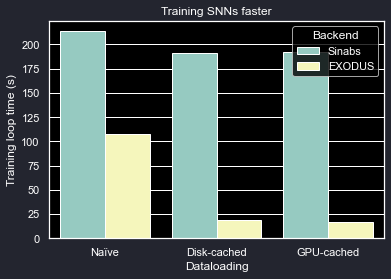

In [33]:
import seaborn as sns

plt.style.use("dark_background")
plt.figure(facecolor='#23252f')
sns.barplot(data=df, x="Dataloading", y="Training loop time (s)", hue="Backend").set(
    title="Training SNNs faster"
);